# RNNs for Time Series

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout
from keras.callbacks import History
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import load_model

ModuleNotFoundError: No module named 'keras'

In [2]:
data_clean = 'coffee_store_sales.csv'
num_days = 30

warnings.filterwarnings('ignore')

## Load Data

In [3]:
df = pd.read_csv(data_clean)

df = df[['trn_date','total_sales']]
df['trn_date'] = pd.to_datetime(df['trn_date'])

df.set_index('trn_date', inplace=True)
df.index.freq = 'D'

df.iloc[[0,-1]]

,total_sales
trn_date,
2023-01-01,2508.20
2023-06-30,5481.32


## Analysis

<Axes: xlabel='trn_date'>

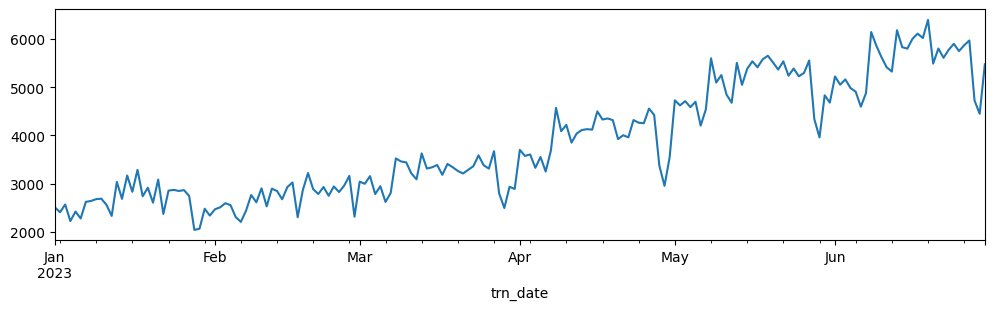

In [4]:
results = seasonal_decompose(df['total_sales'])

results.observed.plot(figsize=(12,3))

<Axes: xlabel='trn_date'>

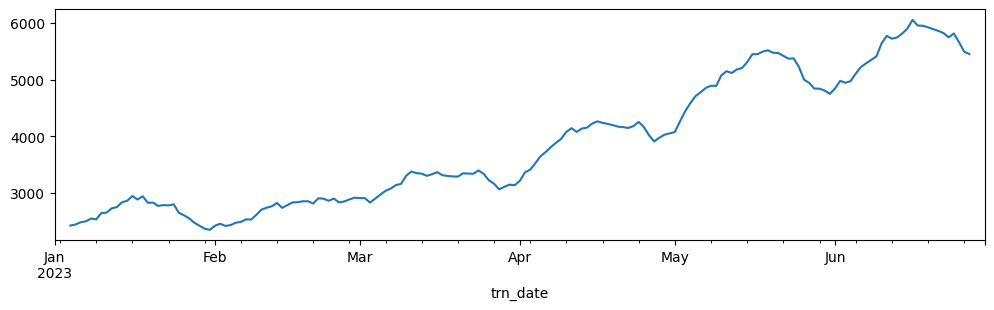

In [5]:
results.trend.plot(figsize=(12,3))

<Axes: xlabel='trn_date'>

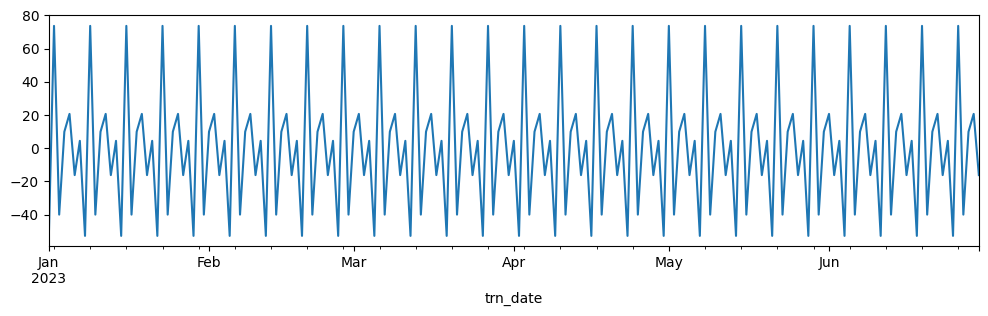

In [6]:
results.seasonal.plot(figsize=(12,3))

<Axes: xlabel='trn_date'>

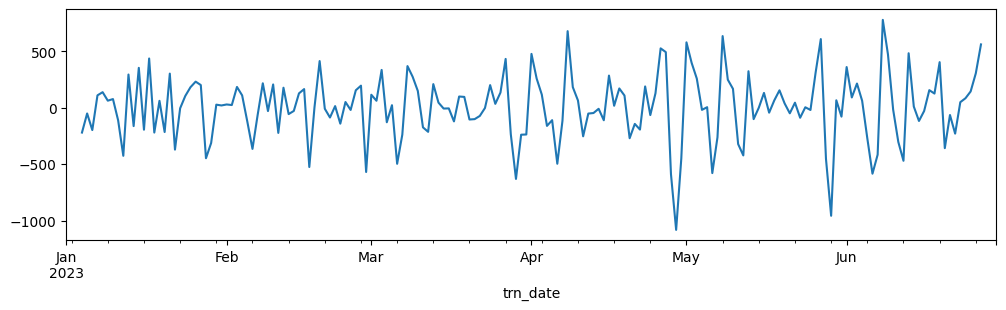

In [7]:
results.resid.plot(figsize=(12,3))

## Split Data

In [8]:
df_train = df.iloc[:-num_days]
df_train.iloc[[0,-1]]

,total_sales
trn_date,
2023-01-01,2508.20
2023-05-31,4684.13


In [9]:
df_test = df.iloc[-num_days:]
df_test.iloc[[0,-1]]

,total_sales
trn_date,
2023-06-01,5227.00
2023-06-30,5481.32


## Scaling Data

In [10]:
scaler = MinMaxScaler()
scaler.fit(df_train)

MinMaxScaler()

In [11]:
scaled_train = scaler.transform(df_train)
scaled_test = scaler.transform(df_test)

print(f'Train:\n{scaled_train[:3]}...')
print(f'Test:\n{scaled_test[:3]}...')

Train:
[[0.13011009]
 [0.10115224]
 [0.14579731]]...
Test:
[[0.88099802]
 [0.83390872]
 [0.86433034]]...


## TS Generator

In [106]:
X = 10
y = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=X, batch_size=y)
# validator = TimeseriesGenerator(scaled_test, scaled_test, length=X, batch_size=y)

In [ ]:
# for num in range(2):
#     var_x, var_y = generator[num]
#     print('Sample', num+1)
#     print('Input X:', var_x)
#     print('Output Y:', var_y)
#     print()

In [99]:
print(f'Train length: {len(scaled_train)}')
print(f'Generator length: {len(generator)}')

Train length: 151
Generator length: 130


## Traning Model

In [69]:
# class MSECallback(Callback):
#     def __init__(self, val_generator):
#         self.val_generator = val_generator
#         self.mse_history = []

#     def on_epoch_end(self, epoch, logs=None):
#         X_val, y_val = self.val_generator[0]
#         y_pred = self.model.predict(X_val)

#         mse = np.mean((y_val - y_pred)**2)
#         self.mse_history.append(mse)
#         print(f'Epoch {epoch+1}: Val MSE = {mse:.2f}')

# # MSECallback
# mse_callback = MSECallback(val_generator=validator)

In [70]:
# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

In [107]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X, y))) #, return_sequences=True))
# model.add(LSTM(300, return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(100))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 100)               40800     
                                                                 
 dense_12 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [113]:
history = model.fit(generator, epochs=300) #, validation_data=validator, callbacks=[mse_callback, early_stopping])

Epoch 1/300
141/141 [==============================] - 1s 5ms/step - loss: 0.0043
Epoch 2/300
141/141 [==============================] - 1s 5ms/step - loss: 0.0041
Epoch 3/300
141/141 [==============================] - 1s 5ms/step - loss: 0.0039
Epoch 4/300
141/141 [==============================] - 1s 5ms/step - loss: 0.0040
Epoch 5/300
141/141 [==============================] - 1s 5ms/step - loss: 0.0041
Epoch 6/300
141/141 [==============================] - 1s 5ms/step - loss: 0.0040
Epoch 7/300
141/141 [==============================] - 1s 5ms/step - loss: 0.0040
Epoch 8/300
141/141 [==============================] - 1s 5ms/step - loss: 0.0038
Epoch 9/300
141/141 [==============================] - 1s 5ms/step - loss: 0.0040
Epoch 10/300
141/141 [==============================] - 1s 5ms/step - loss: 0.0043
Epoch 11/300
141/141 [==============================] - 1s 5ms/step - loss: 0.0040
Epoch 12/300
141/141 [==============================] - 1s 5ms/step - loss: 0.0041
Epoch 13/300


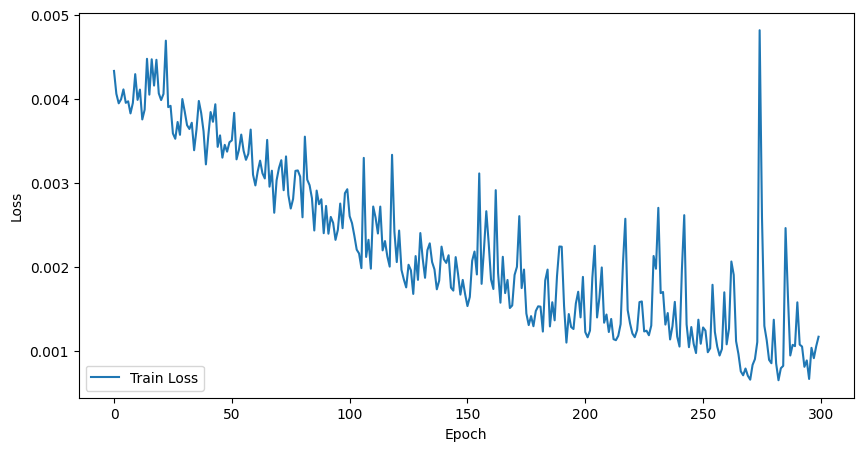

In [114]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [63]:
# plt.figure(figsize=(10,5))
# rmse_values = mse_callback.rmse_history
# plt.plot(rmse_values, label='Val RMSE')

# plt.xlabel('Epoch')
# plt.ylabel('RMSE')
# plt.legend()
# plt.show()

## Predictions

In [ ]:
# first_batch = scaled_train[-X:]
# first_batch = first_batch.reshape((1, X, y)) # (batches, time steps, features)

# print(f'Predict: {model.predict(first_batch)[0]}')
# print(f'Real:    {scaled_test[0]}')

In [115]:
test_pred = []

first_batch = scaled_train[-X:]
current_batch = first_batch.reshape((1, X, y))

for num in range(len(df_test)):
    current_pred = model.predict(current_batch, verbose=False)[0]
    test_pred.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

df_test['predictions'] = scaler.inverse_transform(test_pred)
df_test.sample(3)

,total_sales,predictions
trn_date,,
2023-06-11,5418.61,4112.865564
2023-06-13,6189.36,4519.878339
2023-06-04,4985.15,4652.091328


## Metrics

<Axes: xlabel='trn_date'>

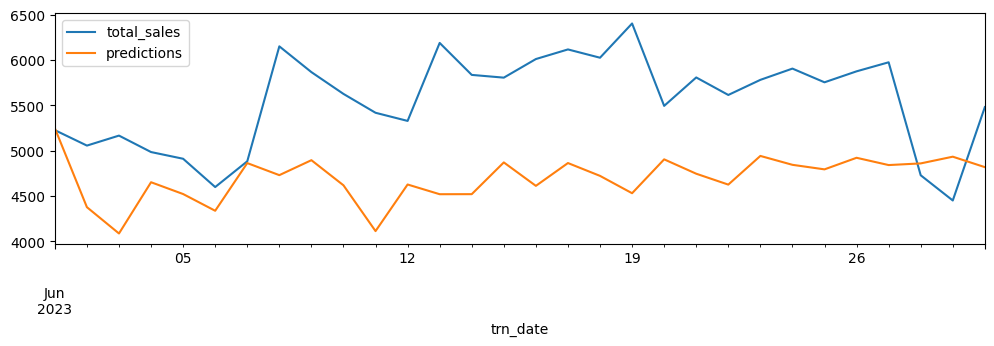

In [116]:
df_test.plot(figsize=(12,3))

In [117]:
rnn_rmse = round(np.sqrt(mean_squared_error(df_test.total_sales, df_test.predictions)),2)
print('RNN RMSE:', rnn_rmse)

RNN RMSE: 1006.1


## Save Model

In [74]:
model.save('rnn_model.h5')

In [77]:
rnn_model = load_model('rnn_model.h5')
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 300)               362400    
                                                                 
 dense_1 (Dense)             (None, 1)                 301       
                                                                 
Total params: 362701 (1.38 MB)
Trainable params: 362701 (1.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# save coffee_predictions.csv